In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("/content/customer_transactions.csv")

In [3]:
df.head(10)

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3
5,120,1006,395,2024-01-06,Groceries,1.1
6,182,1007,91,2024-01-07,Sports,4.9
7,186,1008,429,2024-01-08,Clothing,4.3
8,174,1009,228,2024-01-09,Electronics,3.8
9,174,1010,112,2024-01-10,Sports,2.6


In [4]:
df.dtypes

,0
customer_id_legacy,int64
transaction_id,int64
purchase_amount,int64
purchase_date,object
product_category,object
customer_rating,float64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-null    object 
 4   product_category    150 non-null    object 
 5   customer_rating     140 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ KB


In [6]:
df.describe()

,customer_id_legacy,transaction_id,purchase_amount,customer_rating
count,150.000000,150.000000,150.000000,140.00000
mean,148.760000,1075.500000,280.780000,2.98500
std,30.046425,43.445368,121.329595,1.20699
min,100.000000,1001.000000,51.000000,1.00000
25%,121.250000,1038.250000,179.000000,1.95000
50%,150.500000,1075.500000,274.000000,3.00000
75%,174.750000,1112.750000,388.500000,4.00000
max,199.000000,1150.000000,495.000000,5.00000


#### Data Cleaning & Handling Missing Values with Mean, Median, Mode Imputation

In [7]:
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,10


In [8]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
imputer = KNNImputer(n_neighbors=5)
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

<ipython-input-8-ce8c8e1fea40>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-8-ce8c8e1fea40>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [9]:
df.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151.0,1001.0,408.0,2024-01-01,Sports,2.3
1,192.0,1002.0,332.0,2024-01-02,Electronics,4.2
2,114.0,1003.0,442.0,2024-01-03,Electronics,2.1
3,171.0,1004.0,256.0,2024-01-04,Clothing,2.8
4,160.0,1005.0,64.0,2024-01-05,Clothing,1.3


In [10]:
# Step 3: Verify missing values after basic imputation
print(df.isnull().sum())

customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


In [11]:
target_distribution = df['product_category'].value_counts()

In [12]:
print(target_distribution)

product_category
Sports         35
Electronics    34
Clothing       28
Groceries      28
Books          25
Name: count, dtype: int64


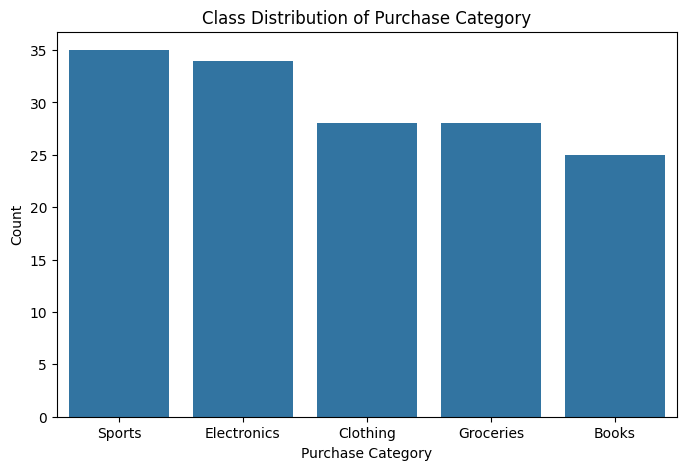

In [13]:
# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='product_category', data=df)
plt.title('Class Distribution of Purchase Category')
plt.xlabel('Purchase Category')
plt.ylabel('Count')
plt.show()

#### Data Augmentation Strategies

In [14]:
noise = np.random.normal(0, 0.1 * df['purchase_amount'].std(), size=df['purchase_amount'].shape)
df['purchase_amount_noisy'] = df['purchase_amount'] + noise
df['purchase_amount_noisy'] = df['purchase_amount_noisy'].clip(lower=0)

In [15]:
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,0
purchase_amount_noisy,0


In [16]:
df.shape

(150, 7)

In [17]:
# Apply SMOTE to balance the dataset
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols_for_smote = [col for col in numerical_cols if col != 'purchase_date']
X = df[numerical_cols_for_smote]
y = df['product_category']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a DataFrame with resampled data, adding back 'purchase_date' and 'product_category'
df_resampled = pd.DataFrame(X_resampled, columns=numerical_cols_for_smote)
# Instead of assigning original values, repeat the purchase_date values to match the new length
df_resampled['purchase_date'] = np.tile(df['purchase_date'].values, int(np.ceil(len(df_resampled) / len(df))))[:len(df_resampled)]
df_resampled['product_category'] = y_resampled

print("\nShape after SMOTE:", df_resampled.shape)
print(df_resampled['product_category'].value_counts())
print(df_resampled.dtypes)


Shape after SMOTE: (175, 7)
product_category
Sports         35
Electronics    35
Clothing       35
Groceries      35
Books          35
Name: count, dtype: int64
customer_id_legacy       float64
transaction_id           float64
purchase_amount          float64
customer_rating          float64
purchase_amount_noisy    float64
purchase_date             object
product_category          object
dtype: object


In [18]:
df_resampled.head()

,customer_id_legacy,transaction_id,purchase_amount,customer_rating,purchase_amount_noisy,purchase_date,product_category
0,151.0,1001.0,408.0,2.3,399.860959,2024-01-01,Sports
1,192.0,1002.0,332.0,4.2,350.238961,2024-01-02,Electronics
2,114.0,1003.0,442.0,2.1,439.735175,2024-01-03,Electronics
3,171.0,1004.0,256.0,2.8,280.081978,2024-01-04,Clothing
4,160.0,1005.0,64.0,1.3,62.992997,2024-01-05,Clothing


In [19]:
# Step 3.2: Feature Value Transformation
for col in numerical_cols:
    skewness = df_resampled[col].skew()
    print(f"Skewness of {col}: {skewness}")
    if skewness > 1:
        df_resampled[f'{col}_log'] = np.log1p(df_resampled[col])

# Display the updated DataFrame
print("\nDataFrame After Feature Transformation:")
print(df_resampled.head())

Skewness of customer_id_legacy: -0.12009813423223016
Skewness of transaction_id: -0.046836822163405234
Skewness of purchase_amount: -0.0050881397545237544
Skewness of customer_rating: -0.10327354018584121
Skewness of purchase_amount_noisy: 0.01253670015803149

DataFrame After Feature Transformation:
   customer_id_legacy  transaction_id  purchase_amount  customer_rating  \
0               151.0          1001.0            408.0              2.3   
1               192.0          1002.0            332.0              4.2   
2               114.0          1003.0            442.0              2.1   
3               171.0          1004.0            256.0              2.8   
4               160.0          1005.0             64.0              1.3   

   purchase_amount_noisy purchase_date product_category  
0             399.860959    2024-01-01           Sports  
1             350.238961    2024-01-02      Electronics  
2             439.735175    2024-01-03      Electronics  
3             28

In [20]:
# Step 3.3: Create 'purchase_amount_noisy' column by adding random noise to 'purchase_amount'
df_resampled['purchase_amount_noisy'] = df_resampled['purchase_amount'] * np.random.uniform(0.9, 1.1, size=len(df_resampled))

# Step 3.4: Data Expansion
augmented_data = []
target_samples_per_class = 42  # Desired number of samples per class

# Group the data by 'product_category' and generate synthetic samples for each group
for category in df_resampled['product_category'].unique():
    category_data = df_resampled[df_resampled['product_category'] == category]
    current_samples = len(category_data)

    # Calculate the number of synthetic samples needed to reach the target
    num_synthetic = max(0, target_samples_per_class - current_samples)

    for _ in range(num_synthetic):
        synthetic_row = category_data.sample(n=1).iloc[0].copy()
        synthetic_row['purchase_amount'] *= np.random.uniform(0.9, 1.1)
        synthetic_row['purchase_amount_noisy'] *= np.random.uniform(0.9, 1.1)
        synthetic_row['transaction_id'] = df_resampled['transaction_id'].max() + 1
        augmented_data.append(synthetic_row)

# Combine original and augmented data
df_augmented = pd.concat([df_resampled, pd.DataFrame(augmented_data)], ignore_index=True)

# Check the shape of the augmented dataset
print("\nShape of Augmented Dataset:", df_augmented.shape)
print("\nClass Distribution After Data Expansion:")
print(df_augmented['product_category'].value_counts())


Shape of Augmented Dataset: (210, 7)

Class Distribution After Data Expansion:
product_category
Sports         42
Electronics    42
Clothing       42
Groceries      42
Books          42
Name: count, dtype: int64


In [21]:
# Step 4: Export the Augmented Data
df_augmented.to_csv('customer_transactions_augmented.csv', index=False)

In [22]:
print(df.isnull().sum())

customer_id_legacy       0
transaction_id           0
purchase_amount          0
purchase_date            0
product_category         0
customer_rating          0
purchase_amount_noisy    0
dtype: int64
